In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
from utils import Predicate,Clause,KnowledgeBase, Propositional
from utils import load_knowledge_base,load_propositional
from models import LTN
import pickle
import numpy as np
import seaborn as sns
sns.set(style="white", context="talk")

In [2]:
def get_accuracy(model,kb):
    results=[]
    for clause in kb.clauses:
        o1,o2=model.forward(clause)
        if o2.data.numpy()[0][0]>0.9:
            results.append(1.0)
        else:
            results.append(0.0)

    return sum(results)/len(kb.clauses)

In [3]:
def test_model(model,kb1, kb2):
    kb_train=kb1.union(kb2)
    optimizor=torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=0.1)
    mone=torch.FloatTensor([-1])
    one=torch.FloatTensor([1])
    average_prob=[]
    averate_loss=[]
    best_accuracy1=0.0
    best_accuracy2=0.0
    for i in tqdm(range(20)):
        optimizor.zero_grad()
        total_probability=0.0
        total_loss=0.0
        for clause in kb_train.clauses:
            loss,prob=model.forward(clause=clause)
            loss.backward(one)
            total_probability+=prob.data.numpy()[0]
            total_loss+=loss.data.numpy()[0]
        optimizor.step()
        average_prob.append(total_probability/len(kb_train.clauses))
        averate_loss.append(total_loss/len(kb_train.clauses))
        accuracy1=get_accuracy(model,kb1)
        accuracy2=get_accuracy(model,kb2)
        if accuracy1+accuracy2>best_accuracy1+best_accuracy2:
            best_accuracy1=accuracy1
            best_accuracy2=accuracy2
    return average_prob,averate_loss,best_accuracy1,best_accuracy2

In [4]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh',change_weight=False))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn',change_weight=False))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

gkbs3=[]
for p in propositionals:
    gkbs3.append(p.generate_knowledge_base('abcdefgh',change_weight=True))
gkb3=gkbs3[0]
for tkb in gkbs3[1:]:
    gkb3=gkb3.union(tkb)
gkbs4=[]
for p in propositionals:
    gkbs4.append(p.generate_knowledge_base('ijklmn',change_weight=True))
gkb4=gkbs4[0]
for tkb in gkbs4[1:]:
    gkb4=gkb4.union(tkb)

In [7]:
emb_dim=10

In [10]:
prob1,loss1,first1,second1=test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=False),
    kb1=kb1.union(gkb1),
    kb2=kb2.union(gkb2)
)
pickle.dump((prob1,loss1,first1,second1), open( "./results/result1.pkl", "wb" ) )

100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


In [11]:
prob2,loss2,first2,second2=test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
    kb1=kb1.union(gkb1),
    kb2=kb2.union(gkb2)
)
pickle.dump((prob2,loss2,first2,second2), open( "./results/result2.pkl", "wb" ) )

100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


In [12]:
prob3,loss3,first3,second3=test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=False),
    kb1=kb1.union(gkb3),
    kb2=kb2.union(gkb4)
)
pickle.dump((prob3,loss3,first3,second3), open( "./results/result3.pkl", "wb" ) )

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


In [13]:
prob4,loss4,first4,second4=test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
    kb1=kb1.union(gkb3),
    kb2=kb2.union(gkb4)
)
pickle.dump((prob4,loss4,first4,second4), open( "./results/result4.pkl", "wb" ) )

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [14]:
prob1,loss1,first1,second1=pickle.load(open('./results/result1.pkl','rb'))
prob2,loss2,first2,second2=pickle.load(open('./results/result2.pkl','rb'))
prob3,loss3,first3,second3=pickle.load(open('./results/result3.pkl','rb'))
prob4,loss4,first4,second4=pickle.load(open('./results/result4.pkl','rb'))

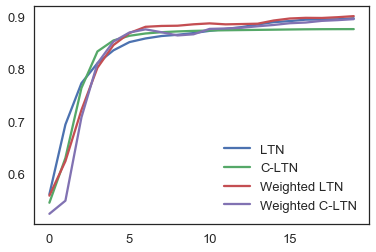

In [15]:
plt.plot(prob1,label='LTN')
plt.plot(prob2,label='C-LTN')
plt.plot(prob3,label='Weighted LTN')
plt.plot(prob4,label='Weighted C-LTN')
plt.legend()
plt.show()

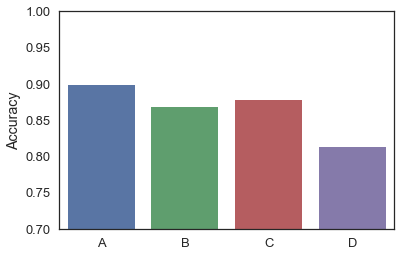

In [18]:
x = np.array(list("ABCD"))
y1 = np.array([first1,first2,first3,first4])
y2 = np.array([second1,second2,second3,second4])
sns.barplot(x, y1)
plt.ylabel("Accuracy")
plt.ylim((0.7,1.0))
plt.show()